# Synthetic Data Generation Model
In this notebook, we run through an experiment using UserALE data generated within an instantiation of Superset. This data reflects four simulated user sessions in which the user performs three tasks within the Video Game Sales example dashboard:

1. Filter the games for Wii, Racing, and Nintendo.
2. Find Mario Kart in the list of games.
3. Determine the difference in global sales between the 3DS game Nintendogs + cats and Wii Sports.

The data of these four sessions is captured in a json file within the data folder entitled `task_example.json`.  In this example, we will:

* Investigate the structure of our data as instantiated by the networkx library's digraph object.
* Plug the digraph obects into various GAN models in pursuit of a satisfactory generator model (loss less than )
* Generate synthetic data similar to the inital log segments using the generator of that GAN

**Note: The data utilized in this example was not data collected in any user study.  Rather this data is simulated through developer interactions with the Superset dashboard.**

## Legacy Example Code
Below we have all the necessary legacy code found in `Distill_Workflow_Example.ipynb` up to the point that digraphs of each session from `task_example.json` are generated.  
**Note: the `sys` module is necessary to allow us to append the system path and thus import distill.  If distill was installed on the machine directly, this would not be necessary.**

**Downloads**

In [6]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install plotly

     ---------------------------------------- 15.2/15.2 MB 7.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install matplotlib

     ---------------------------------------- 7.2/7.2 MB 6.8 MB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
     ---------------------------------------- 55.4/55.4 kB 2.8 MB/s eta 0:00:00
     ------------------------------------- 163.0/163.0 kB 10.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


**Imports**

In [8]:
import sys
sys.path.append('../')

import datetime
import distill
import json
import networkx as nx
import os
import pandas as pd
import plotly.express as px
import re

**Methods**

In [9]:
def setup(file, date_type):
    with open(file) as json_file:
        raw_data = json.load(json_file)

    data = {}
    for log in raw_data:
        data[distill.getUUID(log)] = log
        
    # Convert clientTime to specified type
    for uid in data:
        log = data[uid]
        client_time = log['clientTime']
        if date_type == "integer":
            log['clientTime'] = distill.epoch_to_datetime(client_time)
        elif date_type == "datetime":
            log['clientTime'] = pd.to_datetime(client_time, unit='ms', origin='unix')

    # Sort
    sorted_data = sorted(data.items(), key=lambda kv: kv[1]['clientTime'])
    sorted_dict = dict(sorted_data)

    return (sorted_data, sorted_dict)

def draw_digraph(segments):
    nodes = sorted(segments.get_segment_list(), key=lambda segment: segment.start_end_val[0])
    edges = distill.pairwiseSeq(segments.get_segment_list())
    
    # Set coloring of graph based on element in Superset dashboard
    color_map = []
    for segment in segments:
        if re.match("Game_Filter\S*", segment.segment_name):
            color_map.append('green')
        else:
            color_map.append('blue')
    
    graph = distill.createDiGraph(nodes, edges)
    nx.draw(graph, node_color=color_map)
    return graph

**Segment creation, dissection, and list structuring**

In [12]:
data_many_session = setup("./data/task_example.json", "datetime")
sorted_dict = data_many_session[1]

# Create segments based on sessionID
segments = distill.Segments()
session_ids = sorted(distill.find_meta_values('sessionID', sorted_dict), key=lambda sessionID: sessionID)
for session_id in session_ids:
    segments.append_segments(distill.generate_collapsing_window_segments(sorted_dict, 'sessionID', [session_id], session_id))
    
# Improve readability of Segment names
for index in range(len(segments)):
    segments[index].segment_name = "Session" + str(index)
    
    
segment_names = [segment.segment_name for segment in segments]
start_end_vals = [segment.start_end_val for segment in segments]
segment_map = distill.write_segment(sorted_dict, segment_names, start_end_vals)

session_0_segments = distill.generate_collapsing_window_segments(segment_map['Session0'], 'path', ['div.filter-container css-ffe7is'], "Game_Filter")
session_1_segments = distill.generate_collapsing_window_segments(segment_map['Session1'], 'path', ['div.filter-container css-ffe7is'], "Game_Filter")
session_2_segments = distill.generate_collapsing_window_segments(segment_map['Session2'], 'path', ['div.filter-container css-ffe7is'], "Game_Filter")
session_3_segments = distill.generate_collapsing_window_segments(segment_map['Session3'], 'path', ['div.filter-container css-ffe7is'], "Game_Filter")

session_0_segments.append_segments(distill.generate_collapsing_window_segments(segment_map['Session0'], 'path', ['div#chart-id-110.superset-chart-table'], "Games"))
session_1_segments.append_segments(distill.generate_collapsing_window_segments(segment_map['Session1'], 'path', ['div#chart-id-110.superset-chart-table'], "Games"))
session_2_segments.append_segments(distill.generate_collapsing_window_segments(segment_map['Session2'], 'path', ['div#chart-id-110.superset-chart-table'], "Games"))
session_3_segments.append_segments(distill.generate_collapsing_window_segments(segment_map['Session3'], 'path', ['div#chart-id-110.superset-chart-table'], "Games"))

segments.append_segments(session_0_segments)
segments.append_segments(session_1_segments)
segments.append_segments(session_2_segments)
segments.append_segments(session_3_segments)

**Sessions' segments graph visualization**

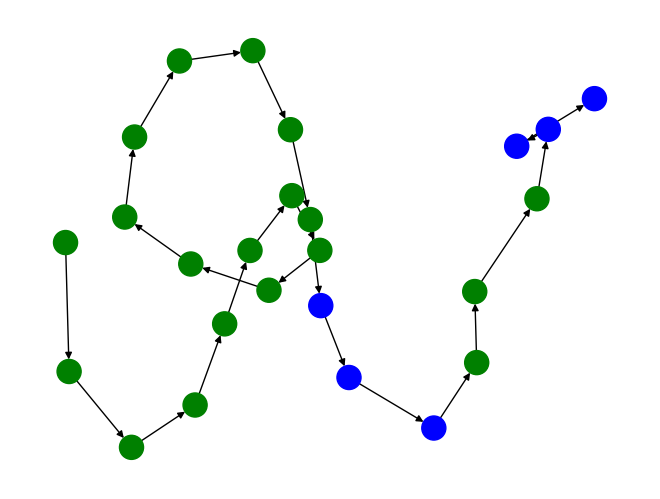

In [15]:
G0 = draw_digraph(session_0_segments)

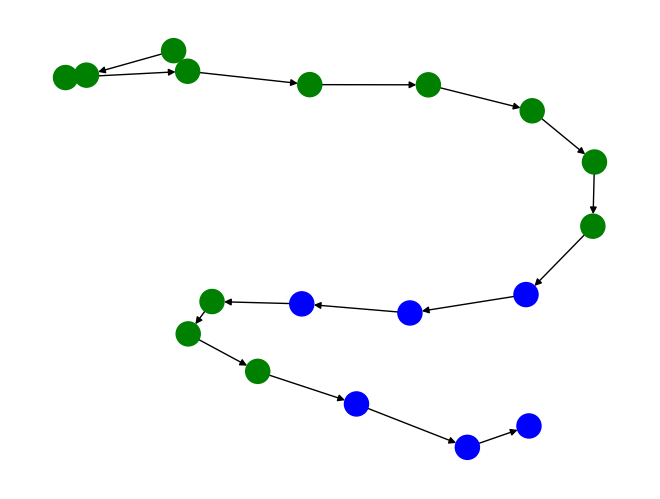

In [16]:
G1 = draw_digraph(session_1_segments)

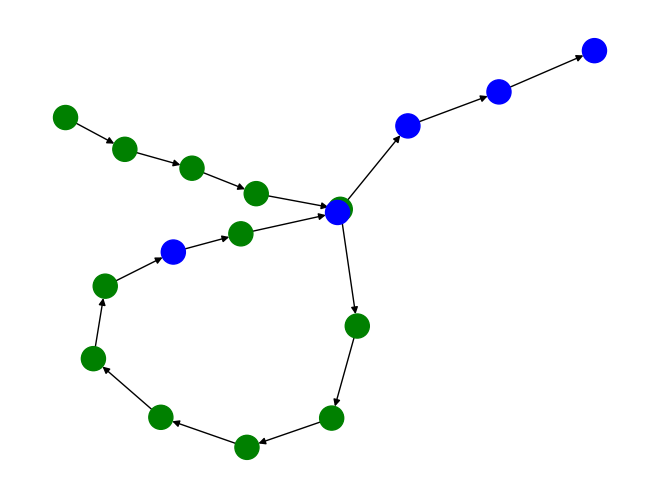

In [17]:
G2 = draw_digraph(session_2_segments)

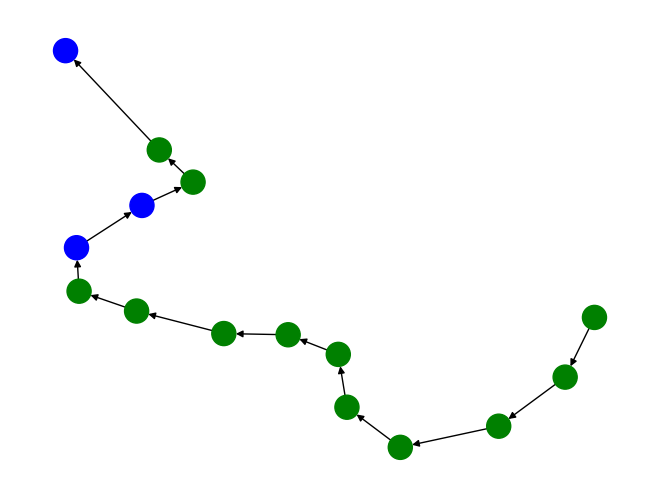

In [18]:
G3 = draw_digraph(session_3_segments)

## Digraph Structural Investigation

In [27]:
nodes = sorted(session_0_segments.get_segment_list(), key=lambda segment: segment.start_end_val[0])
edges = distill.pairwiseSeq(session_0_segments.get_segment_list())
graph = distill.createDiGraph(nodes, edges)
graph

As we can see, the graphs we wish to feed as input and predict are DiGraph objects from the networkx library found at https://networkx.org/documentation/stable/reference/classes/digraph.html

This means we need to find if there are any already existant models or useful research papers using networkx.DiGraph objects or similar graph objects that are easily translated between the two.

**Research**

So far, I've read:
* (theory) https://www.frontiersin.org/articles/10.3389/fdata.2019.00003/full
* (undirected graphs GAN with tensorflow) https://github.com/hwwang55/GraphGAN
* (directed graphs GAN with pytorch) https://github.com/THUDM/GraphSGAN

As a result, I have a good idea of the theory and am currently working out how to reverse-engineer the third link which looks most promising. 

**Current problem:** Having a hard time percieving the third link's input data and how it relates to ours